<a href="https://colab.research.google.com/github/DolevSeren/DI-Bootcamp/blob/main/AI-Powered%20Movie%20Recommendation%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd #Dataframe
import numpy as np # Numerical
from scipy import stats #Statistics
from scipy.cluster.vq import kmeans, vq # k-mean: groups data points into clusters based on similarity.
from collections import defaultdict
import matplotlib.pyplot as plt #Visualization
from scipy.stats import ttest_ind

In [44]:
user_df = pd.read_csv("/content/user_watch_history_extended.csv")
movie_db_df = pd.read_csv("/content/generated_1000_movies.csv")

In [45]:
#Clean Preferences & Build movie_db
# Remove spaces from preferences
user_df["preferences"] = user_df["preferences"].str.replace(" ", "")

# Group by movie & genre to compute average rating
movie_grouped = user_df.groupby(['movie', 'genre']) \
    .agg(avg_rating=('rating', 'mean')).reset_index()

# Build movie_db list of dicts
movie_db = [
    {
        'title': row['movie'],
        'genre': row['genre'],
        'avg_rating': round(row['avg_rating'], 2)
    }
    for _, row in movie_grouped.iterrows()
]
print(movie_grouped)

                      movie        genre  avg_rating
0                      13th  documentary    3.222222
1          A Beautiful Mind        drama    3.265306
2         Bohemian Rhapsody    biography    3.333333
3               Bridesmaids       comedy    2.980000
4         Crazy Rich Asians      romance    3.116279
5                  Die Hard       action    3.016949
6                   Get Out       horror    3.088889
7                 Gladiator       action    3.203704
8                 Gone Girl      mystery    3.000000
9   Guardians of the Galaxy       sci-fi    3.084746
10             Harry Potter      fantasy    3.305556
11                Inception       sci-fi    3.111111
12            Indiana Jones    adventure    3.172414
13               La La Land        drama    2.890909
14                Prisoners      mystery    3.087719
15           Shutter Island     thriller    2.979167
16            Spirited Away    animation    3.000000
17             The Hangover       comedy    3.

In [46]:
#Build User Profiles
users = []
for name, group in user_df.groupby('name'):
    preferences = list(set(','.join(group['preferences']).split(',')))
    watch_history = [
        {
            'movie': row['movie'],
            'genre': row['genre'],
            'rating': row['rating'],
            'date': row.get('date')  # include date if available
        }
        for _, row in group.iterrows()
    ]
    users.append({
        'name': name,
        'preferences': preferences,
        'watch_history': watch_history
    })


In [47]:
#Content-Based Recommendation

# הסבר: ממליץ סרטים על בסיס ז'אנרים מועדפים ודירוגים ממוצעים
def recommend_movies_for_user(user, movie_db, top_n=3):
    preferred_genres = user["preferences"]
    watched_titles = [m['movie'] for m in user['watch_history']]
    candidates = [
        (m['title'], m['avg_rating'])
        for m in movie_db
        if m['genre'] in preferred_genres and m['title'] not in watched_titles
    ]
    return sorted(candidates, key=lambda x: x[1], reverse=True)[:top_n]

# הסבר: מדפיס משפטי המלצה אישיים בסגנון "Since you liked..., you might enjoy..."
def print_recommendation_sentences(user, recommendations):
    if not recommendations:
        print(f"{user['name']} has no recommendations at the moment.")
        return
    watched = [m['movie'] for m in user['watch_history']]
    print(f" Personalized Suggestions for {user['name']}:")
    for rec in recommendations:
        print(f" Since you liked {watched[0]}, you might enjoy {rec[0]} (Rating: {rec[1]})")


In [48]:
#Collaborative Filtering (User Similarity)

# הסבר: ממיר היסטוריית דירוגים לווקטור לפי כל כותרות הסרטים
def user_rating_vector(user, movie_db):
    titles = [m["title"] for m in movie_db]
    ratings = {h["movie"]: h["rating"] for h in user["watch_history"]}
    return [ratings.get(t, 0) for t in titles]

# הסבר: מחשב קורלציה בין דירוגי משתמש יעד לבין אחרים ומחזיר דמיון בסדר יורד
def find_similar_users(users, target_idx):
    target_vec = user_rating_vector(users[target_idx], movie_db)
    sims = []
    for i, u in enumerate(users):
        if i == target_idx: continue
        vec = user_rating_vector(u, movie_db)
        try:
            corr, _ = stats.pearsonr(target_vec, vec)
        except:
            corr = 0
        sims.append((i, corr))
    return sorted(sims, key=lambda x: x[1], reverse=True)


In [49]:
#Clustering Users by Genre Preferences

# הסבר: ממיר רשימת ז'אנרים של משתמש לווקטור בינארי
def genres_to_vector(user, all_genres):
    return [1 if g in user["preferences"] else 0 for g in all_genres]

# הסבר: מבצע ק-מינס על וקטורי ז'אנר כדי לקבץ משתמשים לתוך k אשכולות
def cluster_users(users, k=3):
    all_genres = sorted({g for u in users for g in u["preferences"]})
    data = np.array([genres_to_vector(u, all_genres) for u in users], dtype=float)
    centroids, _ = kmeans(data, k)
    idx, _ = vq(data, centroids)
    clusters = defaultdict(list)
    for i, cid in enumerate(idx):
        clusters[cid].append(users[i]['name'])
    return clusters


In [50]:
#Example Calls for Recommendations, Similarity & Clusters
user_idx = 260
recs = recommend_movies_for_user(users[user_idx], movie_db)
print_recommendation_sentences(users[user_idx], recs)

print("\nMost similar users:")
for i, sim in find_similar_users(users, user_idx)[:3]:
    print(f" {users[i]['name']} (Similarity: {sim:.2f})")

print("\nUser Clusters:")
for cid, names in cluster_users(users, k=3).items():
    print(f" Cluster {cid+1}: {names}")


 Personalized Suggestions for Michael:
 Since you liked The King's Speech, you might enjoy Bohemian Rhapsody (Rating: 3.33)
 Since you liked The King's Speech, you might enjoy Gladiator (Rating: 3.2)
 Since you liked The King's Speech, you might enjoy Indiana Jones (Rating: 3.17)

Most similar users:
 Rachel (Similarity: 0.53)
 Jason (Similarity: 0.52)
 Pamela (Similarity: 0.51)

User Clusters:
 Cluster 2: ['Aaron', 'Albert', 'Alexa', 'Alexander', 'Alexandra', 'Alexis', 'Alice', 'Alisha', 'Alison', 'Allen', 'Allison', 'Ana', 'Angel', 'Anita', 'Ann', 'Anna', 'Annette', 'Antonio', 'April', 'Ariel', 'Arthur', 'Ava', 'Belinda', 'Beth', 'Betty', 'Brad', 'Brandi', 'Brandy', 'Brent', 'Brianna', 'Bridget', 'Brittney', 'Bruce', 'Bryan', 'Bryce', 'Caitlin', 'Cameron', 'Carla', 'Carlos', 'Carol', 'Carolyn', 'Casey', 'Cathy', 'Chad', 'Chase', 'Cheryl', 'Chris', 'Christina', 'Cindy', 'Cody', 'Cole', 'Colin', 'Colton', 'Corey', 'Cristian', 'Curtis', 'Daisy', 'Dana', 'Danielle', 'Darlene', 'Deanna', 

In [ ]:
#Visualization Functions

# הסבר: מציג היסטוגרמת התפלגות דירוגים של משתמש
def plot_rating_distribution(user):
    ratings = [h["rating"] for h in user["watch_history"]]
    plt.figure(figsize=(6, 4))
    plt.hist(ratings, bins=range(1,7), edgecolor='black', align='left')
    plt.title(f"Rating Distribution - {user['name']}")
    plt.xlabel("Rating"); plt.ylabel("Frequency")
    plt.xticks(range(1,6)); plt.grid(True); plt.tight_layout()
    plt.show()

# הסבר: מציג עמודות עם מספר סרטים שצפה בהם המשתמש בכל ז'אנר
def plot_top_genres(user):
    genres = [h["genre"] for h in user["watch_history"]]
    counts = pd.Series(genres).value_counts()
    plt.figure(figsize=(8,4))
    counts.plot(kind='bar')
    plt.title(f"Top Genres Watched - {user['name']}")
    plt.xlabel("Genre"); plt.ylabel("Count"); plt.grid(axis='y')
    plt.tight_layout(); plt.show()

# הסבר: מציג קו מגמה של דירוגי המשתמש על פני ציר הזמן
def plot_rating_trend(user):
    df = pd.DataFrame(user['watch_history'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    plt.figure(figsize=(8,4))
    plt.plot(df['date'], df['rating'], marker='o')
    plt.title(f"Rating Trend Over Time - {user['name']}")
    plt.xlabel("Date"); plt.ylabel("Rating")
    plt.grid(True); plt.tight_layout(); plt.show()


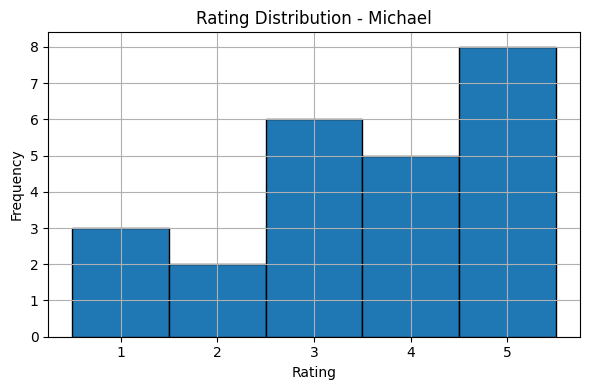

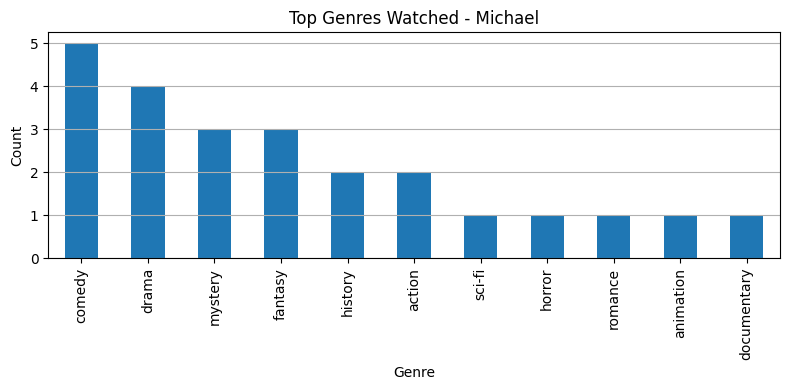

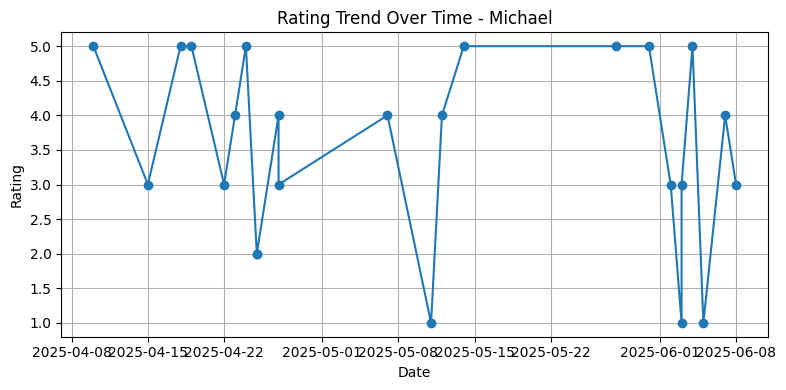

In [ ]:
#Plot Visualizations for One User
plot_rating_distribution(users[user_idx])
plot_top_genres(users[user_idx])
plot_rating_trend(users[user_idx])


In [ ]:
#Aggregate Genre Distributions
def plot_genre_preference_distribution(users):
    all_genres = [g for u in users for g in u["preferences"]]
    counts = pd.Series(all_genres).value_counts()
    plt.figure(figsize=(8,5))
    counts.plot(kind='bar')
    plt.title("🎯 Genre Preference Across All Users")
    plt.xlabel("Genre"); plt.ylabel("User Count")
    plt.grid(axis='y'); plt.tight_layout(); plt.show()

def plot_movie_genre_distribution(movie_db):
    genres = [m['genre'] for m in movie_db]
    counts = pd.Series(genres).value_counts()
    plt.figure(figsize=(8,5))
    counts.plot(kind='bar')
    plt.title("Genre Distribution in Movie Database")
    plt


<ipython-input-40-6fa69de9b9bd>:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.grid(axis='y'); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


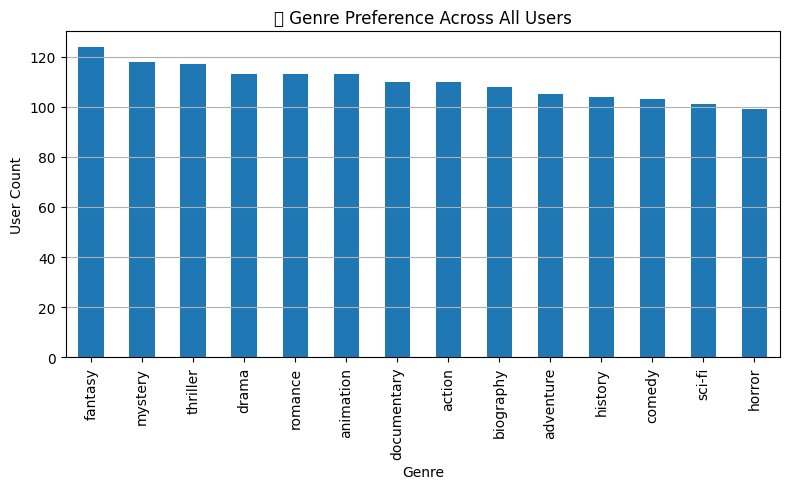

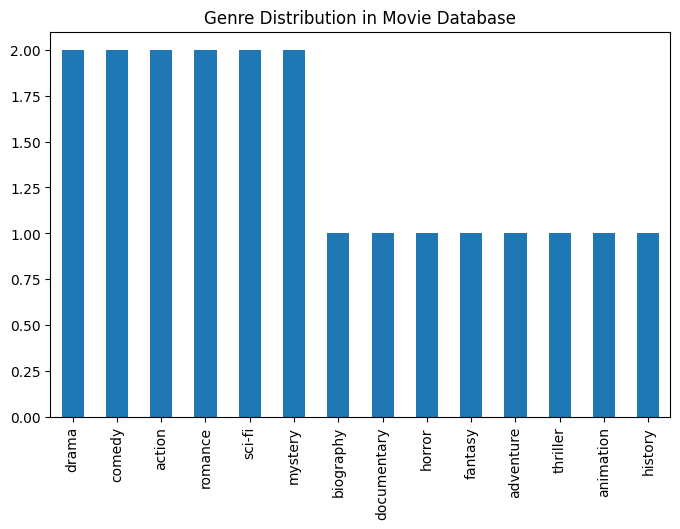

In [ ]:
# Cell 11: Plot Aggregate Distributions
plot_genre_preference_distribution(users)
plot_movie_genre_distribution(movie_db)


In [ ]:
#T-Test Between Two Users

# Perform an independent t-test to compare two users' rating distributions
def t_test_between_users(user1, user2):
    r1 = [h["rating"] for h in user1["watch_history"]]
    r2 = [h["rating"] for h in user2["watch_history"]]
    if len(r1)<2 or len(r2)<2:
        print("❗ Not enough data to perform t-test."); return
    t_stat, p = ttest_ind(r1, r2, equal_var=False)
    print(f"T-Test between {user1['name']} & {user2['name']}: t={t_stat:.3f}, p={p:.4f}")
    print(" Significant difference" if p<0.05 else " No significant difference")

# Example invocation
t_test_between_users(users[185], users[260])


T-Test between John & Michael: t=0.202, p=0.8411
 No significant difference
